In [324]:
!pip install SimPEG

In [325]:
import numpy as np
import scipy.sparse as sp
from SimPEG import Mesh, Utils, Solver
from scipy.constants import mu_0, epsilon_0
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/sgkang/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['fmax', 'f', 'fmin']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Simulation of 1D magnetotelluric problem

##  Purpose

With SimPEG's mesh class, we discretize Maxwell's equations for a 1D magnetotelluric problem, solve both electric and magnetic fields, and evaluate data at a receing location. There are some mile stones to be accomplished:

- Understand terminology behind SimPEG mesh class

- Set up a boundary condition

- Set up an linear system $\mathbf{A}\mathbf{u} = \mathbf{rhs}$, compute the fields, $\mathbf{u}$

- Evaluate the data at a receiver location: apparent resistivity and phase

- Recognize extensibility of this example to higher dimensions: 2D and 3D

## Physics: Maxwell's equations

$$\nabla \times \mathbf{E} = -\imath\omega \mu \mathbf{H}$$

$$\nabla \times \mathbf{H} + \hat{\sigma} \mathbf{E} = 0$$

where $\hat{\sigma} = \sigma+\imath \omega \epsilon $

Assume a setup downward propagating plane wave having only: $E_x$ and $H_y$ components


$$ \frac{\partial E_x}{\partial z}  + \imath \omega \mu H_y = 0$$

$$-\frac{\partial H_y}{\partial z} +  \hat{\sigma} E_x = 0$$

with Boundary conditions:

- $E_x (z=0) = 1$

- $E_x (z=-\infty) = 0$

## Discretizations: 

$$ \mathbf{Grad} \ \mathbf{E}_x + \imath \omega \mathbf{M}^{f2cc}_{\mu} \ \mathbf{H}_y  = - \mathbf{B}\mathbf{E}_x^{bc}$$

$$ \mathbf{M}^{cc}_{\hat{\sigma}} \ \mathbf{E}_x + \mathbf{Div} \ \mathbf{H}_y  = \boldsymbol{0}$$


- $\mathbf{E}_x$: Discrete $E_x$ component $[nC \times 1]$

- $\mathbf{H}_y$: Dicrete $H_x$ component $[(nC+1) \times 1]$

- $ \mathbf{Grad}$: Discrete gradient operator $[nC \times (nC+1)]$

- $ \mathbf{Div}$: Discrete divergence operator $[(nC+1) \times nC]$

- $\mathbf{M}^{f2cc}_{\mu}$: $\mathbf{diag}(\mathbf{Av}^T  \boldsymbol{\mu})$ $[(nC+1) \times (nC+1)]$

- $\mathbf{M}^{cc}_{\hat{\sigma}}$: $\mathbf{diag}(\boldsymbol{\hat{\sigma}})$ $[nC \times nC]$

### Questions:

- Explain why $\mathbf{Div} \approx -\mathbf{Grad}^T$? Which condition is required to satisfiy equaility? $\mathbf{Div} = -\mathbf{Grad}^T$


- What are the sizes of $\mathbf{E}_x^{bc}$ and $\mathbf{B}$ ?

## Step1: set up an 1D mesh

### Questions:

- What is the skin depth when $\sigma$ = 0.01 S/m and $f$ = 10 Hz?


- Let us assume that our frequency band of interest is 0.01-1000 Hz. To capture diffusive EM wave how many cells are required for a skin depth? (You may want to use the highest freuquency)


- How much padding distance is required to satisfiy our boundary condition: $E_x (z=-\infty) = 0$ ? (You may want to use the lowest freuquency)


In [326]:
fmax, fmin = 1e3, 1e-2
print ("Smallest cell size = %d m") % (500*np.sqrt(100/fmax) / 4.)
print ("Padding distance = %d m") % (500*np.sqrt(100/fmin) * 2)

Smallest cell size = 39 m
Padding distance = 100000 m


122984.329251


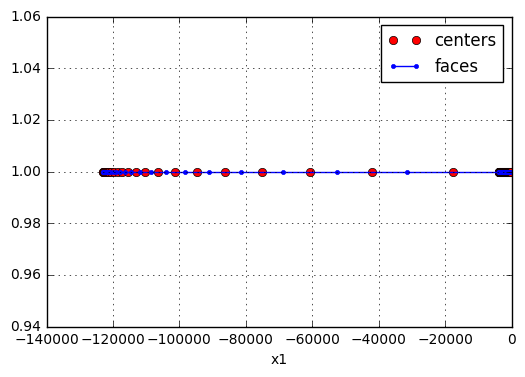

In [327]:
cs = 39.
npad = 25
ncz = 100
hz = [(cs, npad, 1.3), (cs, ncz)]
mesh = Mesh.TensorMesh([hz], x0='N')
mesh.plotGrid(centers=True, faces=True)
plt.legend(("centers", "faces"))
print mesh.hx.sum()

## Step2: Create discrete operators

In [328]:
mu = np.ones(mesh.nC)*mu_0 # magnetic permeability values for all cells
sigma = np.ones(mesh.nC)*0.01 # conductivity values for all cells
epsilon = np.ones(mesh.nC)*epsilon_0 # dielectric constant values for all cells
frequency = 1. # Frequency (Hz)
omega = 2*np.pi*frequency # Angular frequency (rad/s)
sigmahat = sigma # Assume sigmahat = sigma
# In reality ...
# sigmahat = sigma + 1j*epsilon*omega # sigmahat = sigma + 1j*omega*epsilon
Div = mesh.faceDiv # Divergence matrix
mesh.setCellGradBC([['dirichlet', 'dirichlet']]) # Setup boundary conditions
Grad = mesh.cellGrad # Gradient matrix
B = mesh.cellGradBC  # a matrix for boundary conditions
Exbc = np.r_[1., 0.] # boundary values for Ex
Msighat = Utils.sdiag(sigmahat) 
Mmu = Utils.sdiag(mesh.aveF2CC.T * mu) 

## What to solve?

$$ \mathbf{Grad} \ \mathbf{E}_x + \imath \omega \mathbf{M}^{f2cc}_{\mu} \ \mathbf{H}_y  = - \mathbf{B}\mathbf{E}_x^{bc}$$

$$ \mathbf{M}^{cc}_{\hat{\sigma}} \ \mathbf{E}_x + \mathbf{Div} \ \mathbf{H}_y  = \boldsymbol{0}$$

Above discrete Maxwell's equations can be expressed as 

$$\mathbf{A}\mathbf{u} = \mathbf{rhs}$$

where 

- $\mathbf{A} =  \begin{bmatrix}
       \mathbf{Grad} & \imath \omega \mathbf{M}^{f2cc}_{\mu} \\[0.3em]
       \mathbf{M}^{cc}_{\hat{\sigma}} & \mathbf{Div}           \\[0.3em]
     \end{bmatrix}$


- $\mathbf{u} = \begin{bmatrix}
       \mathbf{E}_x \\[0.3em]
       \mathbf{H}_y \\[0.3em]
    \end{bmatrix}$


- $\mathbf{rhs} = \begin{bmatrix}
       - \mathbf{B}\mathbf{E}_x^{bc} \\[0.3em]
       \boldsymbol{0} \\[0.3em]
    \end{bmatrix}$


In [329]:
tempUp = sp.hstack((Grad, 1j*omega*Mmu)) # Top row of A matrix
tempDw = sp.hstack((Msighat, Div)) # Bottom row of A matrix
A = sp.vstack((tempUp, tempDw)) # Full A matrix
rhs = np.r_[-B*Exbc, np.zeros(mesh.nC)] # Right-hand side

In [330]:
Ainv = Solver(A) # Factorize A matrix
sol = Ainv*rhs   # Solve A^-1 rhs = sol
Ex = sol[:mesh.nC] # Extract Ex from solution vector u
Hy = sol[mesh.nC:mesh.nC+mesh.nN] # Extract Hy from solution vector u

## Step3: Compute Impedance, apparent resistivity, and phase

add links

In [ ]:
Zxy = - 1./Hy[0] # Impedance
app_res = abs(Zxy)**2 / (mu_0*omega)
app_phase = np.rad2deg(np.arctan(Zxy.imag / Zxy.real))

In [332]:
print ("Apparent resitivity = %.f Ohm-m") % (app_res)

Apparent resitivity = 100 Ohm-m


In [333]:
print ("Apparent phase =  %.f degree") % (app_phase)

Apparent phase =  45 degree


## Explore
- Write a MT simulation function that can compute apparent resistivity and phase at each frequency (Use quasi-static approximation for this case)

In [334]:
def MTsimulation(mesh, sigma, frequency):
    """
       Compute apparent resistivity and phase at each frequency
    """
    
    return app_res, app_phase

- Check the accuracy for frequency band = 0.1-1000 Hz (plot both apparent resistiity and phase as a function of frequency)

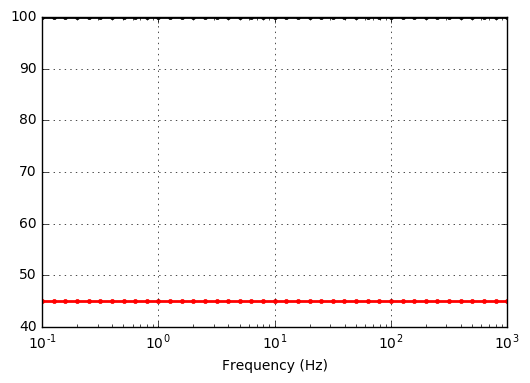

In [335]:
freq = np.logspace(-1, 3, 41)
app_res_vec = np.ones_like(freq) / 0.01 # You need to get this by you MTsimulation function
app_phase_vec = np.ones_like(freq) *45. # You need to get this by you MTsimulation function
plt.semilogx(freq, app_res_vec, lw=2, color="k", marker=".")
plt.semilogx(freq, app_phase_vec, lw=2, color="r", marker=".")
plt.xlabel("Frequency (Hz)")
plt.grid(True)

- Now you are okay with accuracy of this algorithm for the given frequency band. Generate conductivity structure suggested below:

    From 0 to -1000 m: 0.01 S/m
    
    From -1000 to -2000 m: 0.1 S/m    
    
    From -2000 to -$\infty$ m: 0.001 S/m      
    
- Use you MT simulation function, compute apparent resistivity and phase for the givnen frequency band, plot your results similar to above, and explain the results

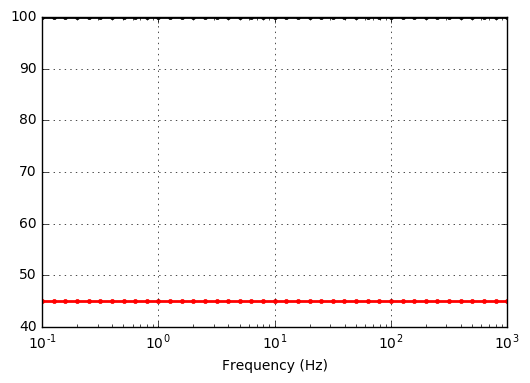

In [336]:
freq = np.logspace(-1, 3, 41)
app_res_vec = np.ones_like(freq) / 0.01 # You need to get this by you MTsimulation function
app_phase_vec = np.ones_like(freq) *45. # You need to get this by you MTsimulation function
plt.semilogx(freq, app_res_vec, lw=2, color="k", marker=".")
plt.semilogx(freq, app_phase_vec, lw=2, color="r", marker=".")
plt.xlabel("Frequency (Hz)")
plt.grid(True)

- Quasi-static approximation was used to compute both the system and data (apparent resistivity and phase), now add displacement current term ($\imath \omega \epsilon E_x$) to your system, and compute the data. 


- Recognize the frequency where you have recognizable error, and explain why. 